# Analyzing genotype-phenotype maps
Example and homework for Genome Sciences 541, by Jesse Bloom, June-2019.

The questions in this notebook are due by **5 PM on Thursday June 13**.

## Import Python modules

In [1]:
import matplotlib.pyplot as plt
plt.ion()

import pandas as pd

import scipy

## Create an additive genotype-phenotype map
Define a class that sets up an additive model for phenotypes and randomly assigns effects to each mutation at each site:

In [2]:
class AdditiveModel:
    """Additive genotype-phenotype model.
    
    Parameters
    ----------
    alphabet : list
        List of characters in the alphabet for the sequences.
    wtseq : str
        The wildtype sequence.
    seed : int
        The random number seed for initializing model parameters
    
    Attributes
    ----------
    alphabet : list
        List of characters in the alphabet for the sequences.
    wtseq : str
        The wildtype sequence.
    seqlength : int
        Length of sequences.
    wtpheno : float
        Phenotype of wildtype sequence.
    site_effects : dict
        Keyed by `(site, a)` where `site` is site in 0, 1, ... numbering and
        `s` is each possible letter in alphabet; values are effects of mutations.
    """
    
    def __init__(self,
                 alphabet,
                 wtseq,
                 seed=1):
        """See main class docstring for how to initialize."""
        self.alphabet = alphabet
        self.wtseq = wtseq
        for a in wtseq:
            if a not in alphabet:
                raise ValueError(f"wtseq contains character not in alphabet: {a}")
        self.seqlength = len(wtseq)
        
        scipy.random.seed(seed)
        self.wtpheno = scipy.random.normal(2)
        self.site_effects = {}
        for r, a_wt in enumerate(self.wtseq):
            for a in self.alphabet:
                if a == a_wt:
                    self.site_effects[(r, a)] = 0
                else:
                    self.site_effects[(r, a)] = scipy.random.normal(-1, 2)
                    
    def muteffects_table(self):
        """Table of effects of all mutations
        
        Returns
        -------
        pandas DataFrame
            Columns give site, wildtype identity, mutation, and its effect.
        """
        return (pd.Series(self.site_effects)
                .rename_axis(['site', 'mutation'])
                .reset_index(name='muteffect')
                .assign(wildtype=lambda x: x['site'].apply(lambda r: self.wtseq[r]))
                [['site', 'wildtype', 'mutation', 'muteffect']]
                .query('wildtype != mutation')
                .reset_index(drop=True)
                )
    
    def all_seqs_phenos(self):
        """Get all possible sequences and their phenotypes.
        
        Returns
        ---------
        dict
            Keyed by all possible sequences, values are their phenotypes.
        """
        # recursive function to build all sequences
        def _add_letter(seqlist):
            if len(seqlist[0]) == self.seqlength:
                return seqlist
            newseqlist = []
            for seq in seqlist:
                for a in self.alphabet:
                    newseqlist.append(seq + a)
            return _add_letter(newseqlist)
            
        allseqs = _add_letter(self.alphabet)
        return {seq: sum(self.site_effects[(r, a)] for r, a in enumerate(seq)) + self.wtpheno
                for seq in allseqs}

Now create an additive model:

In [3]:
add_model = AdditiveModel(['0', '1'], '0000')

Here are the effects of mutations:

In [4]:
add_model.muteffects_table()

,site,wildtype,mutation,muteffect
0,0,0,1,-2.223513
1,1,0,1,-2.056344
2,2,0,1,-3.145937
3,3,0,1,0.730815


Here are all the genotypes and their phenotypes in a nice data frame:

In [5]:
gp_df = (pd.Series(add_model.all_seqs_phenos())
         .rename_axis('genotype')
         .reset_index(name='phenotype')
         )
gp_df

,genotype,phenotype
0,0000,3.624345
1,0001,4.355161
2,0010,0.478408
3,0011,1.209223
4,0100,1.568002
5,0101,2.298817
6,0110,-1.577935
7,0111,-0.847120
8,1000,1.400833
9,1001,2.131648


Here is the distribution of phenotypes:

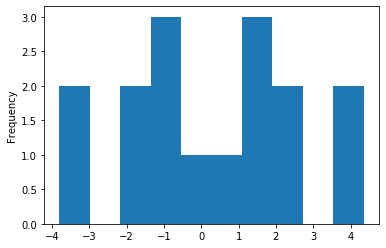

In [6]:
gp_df['phenotype'].plot.hist()